In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import os
from constants import (DATASET_SALE, EXPORT_DIR, T, DATA_DIR, VAL_THRESHOLD, TEST_THRESHOLD)
# from collections import defaultdict

In [2]:
import matplotlib.pyplot as plt
FONT_SIZE = 24
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
%config InlineBackend.figure_format ='retina'

In [3]:
%%time
df = pd.read_csv(DATASET_SALE+'kz.csv',engine='c', sep=',',usecols=["product_id","event_time","user_id",'category_code'],
                 dtype={'product_id': np.int64, 'user_id': np.float64, 'category_code': str},
                 infer_datetime_format=True, parse_dates=[0])

Wall time: 37.3 s


In [4]:
df.shape

(2633521, 4)

### Drop guest users

In [5]:
print(f'We have {T.R}{len(df[df["user_id"]==0]):,}{T.E} events with user_id being {T.b}0{T.E}.')

We have 0 events with user_id being 0.


In [6]:
mask = df["user_id"].isna()
df.loc[mask,"user_id"] = 0
df["user_id"] = df["user_id"].astype("int64")

In [7]:
print(f'Now we have {T.G}{len(df[df["user_id"]==0]):,}{T.E} events with user_id being {T.b}0{T.E}, meaning guest users.')

Now we have 2,069,352 events with user_id being 0, meaning guest users.


In [8]:
# Drop guest users
df = df[df["user_id"]!=0]

In [9]:
df.shape

(564169, 4)

### Drop wrong event time

In [10]:
df = df[df.event_time>'2019']

In [11]:
df.shape

(562862, 4)

### Drop missing categories

In [12]:
df.dropna(inplace=True)

In [13]:
df.shape

(433938, 4)

# Info

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433938 entries, 0 to 2633520
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     433938 non-null  datetime64[ns, UTC]
 1   product_id     433938 non-null  int64              
 2   category_code  433938 non-null  object             
 3   user_id        433938 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(1)
memory usage: 16.6+ MB


In [15]:
print(f'There are {len(df.category_code.value_counts())} categories in the dataframe slice.')

There are 123 categories in the dataframe slice.


In [16]:
df.category_code.value_counts().head(50)

electronics.smartphone                    102554
computers.notebook                         25918
appliances.kitchen.refrigerators           20285
electronics.audio.headphone                20055
electronics.video.tv                       17625
appliances.environment.vacuum              15965
appliances.kitchen.washer                  14565
appliances.kitchen.kettle                  12713
computers.peripherals.mouse                12662
furniture.kitchen.table                    11233
appliances.kitchen.hood                     9053
appliances.kitchen.blender                  8668
appliances.iron                             8233
appliances.kitchen.microwave                7615
appliances.environment.air_conditioner      7378
appliances.personal.scales                  6714
computers.network.router                    6473
electronics.clocks                          6468
electronics.tablet                          6393
stationery.battery                          5183
computers.components

## Purchase fluctuation of registered users during the observed daterange

In [17]:
fluct = df.loc[:,['event_time','user_id']]
fluct['day'] = fluct['event_time'].apply(lambda s: str(s)[0:10])

In [18]:
daily_visitors = fluct.drop_duplicates().groupby(['day'])['user_id'].agg(['count']).sort_values(by=['day'], ascending=True)
daily_visitors.head(3)

,count
day,
2020-01-05,325
2020-01-06,321
2020-01-07,373


In [19]:
daily_visitors.tail(3)

,count
day,
2020-11-19,4173
2020-11-20,512
2020-11-21,223


In [20]:
X = pd.Series(daily_visitors.index.values).apply(lambda s: dt.strptime(s, '%Y-%m-%d').date())

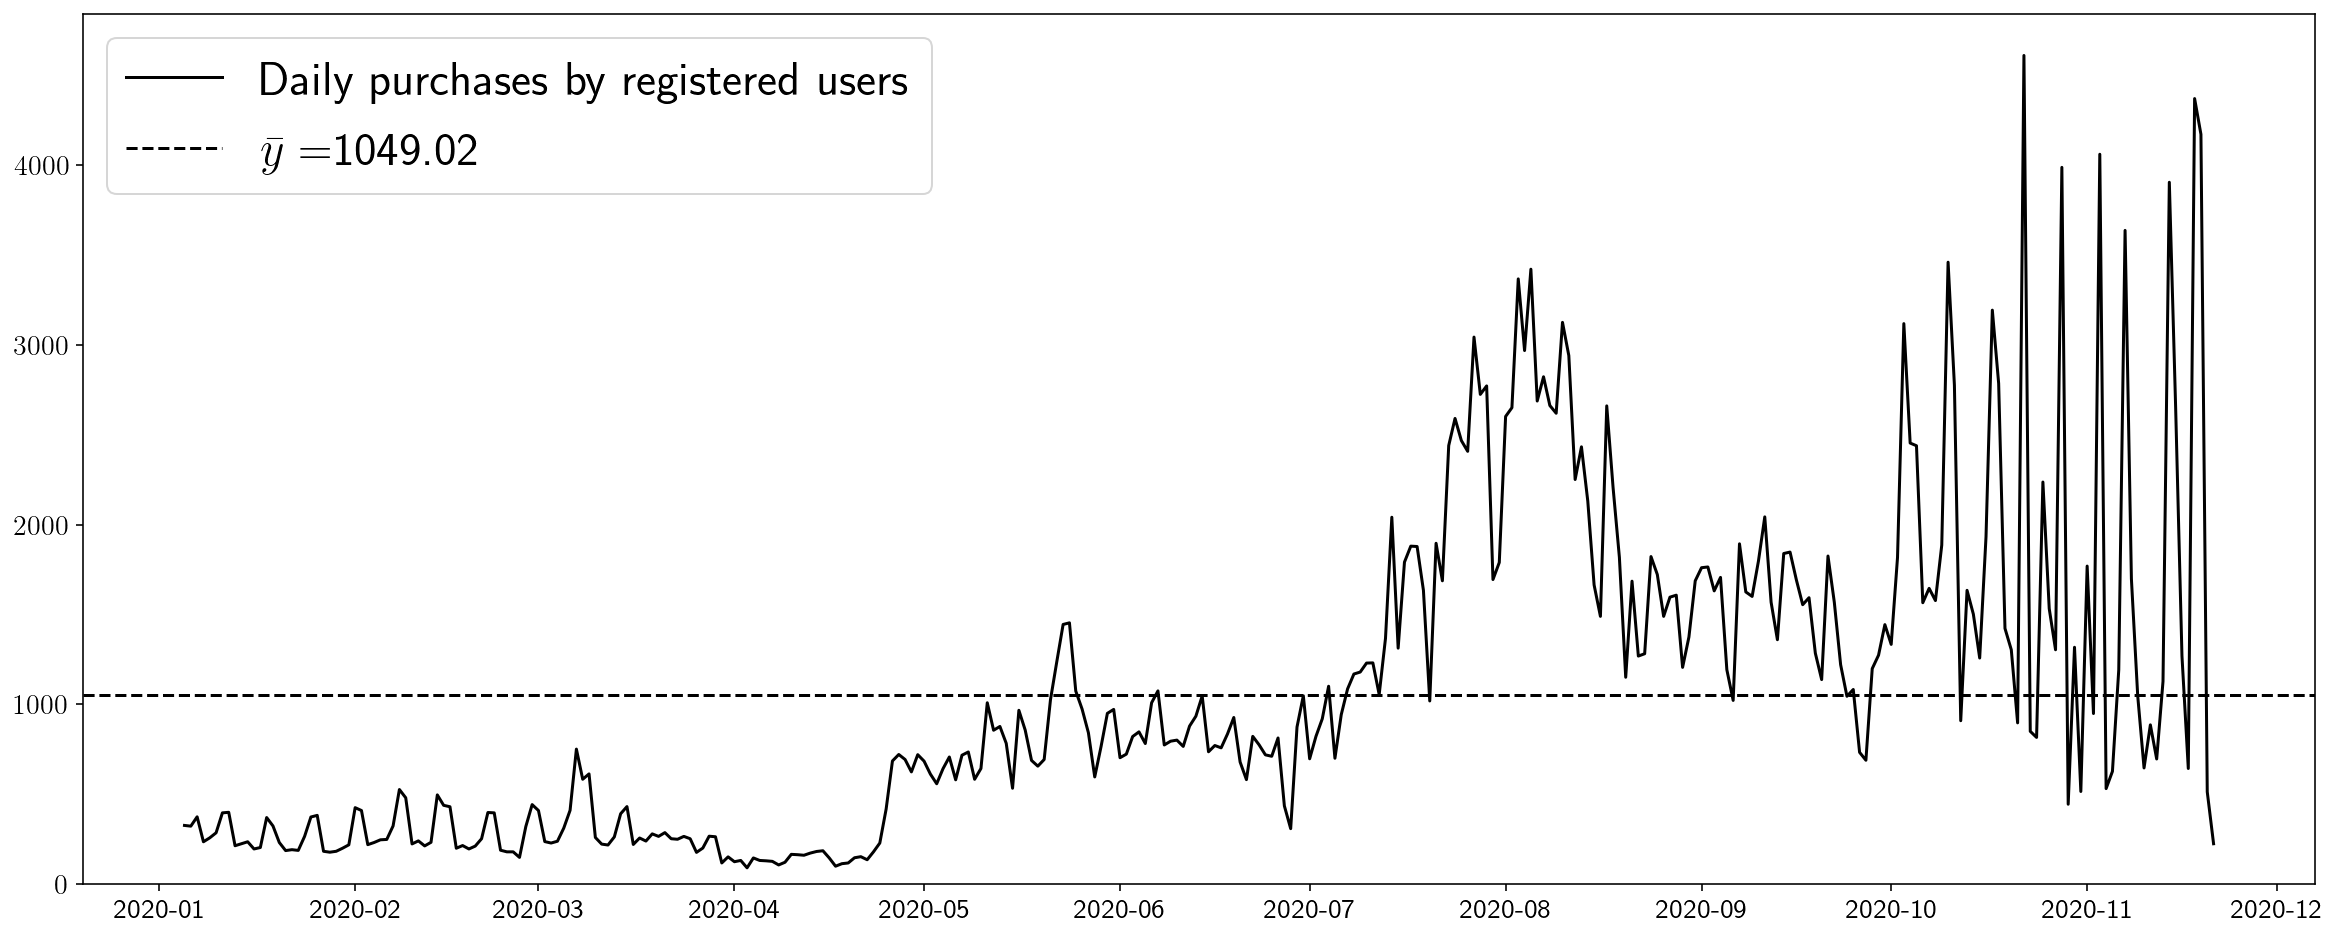

In [21]:
ax = plt.subplot()

plt.plot(X,daily_visitors['count'],color='k')
plt.ylim((0,daily_visitors['count'].max()*1.05))
plt.axhline(y = daily_visitors.mean()[0],linestyle='--', color='k')

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)

plt.legend(['Daily purchases by registered users', r"$\bar{y}=$"+f"{daily_visitors.mean()[0]:.2f}"])
plt.savefig(EXPORT_DIR+'fe-daily-purchases-registered.png',dpi=300)
plt.savefig(EXPORT_DIR+'fe-daily-purchases-registered.pdf')
plt.show()

In [22]:
df[['cat','subcat','deepcat']] = df.category_code.str.split(".",expand=True)

In [23]:
print(f"{len(df.category_code.value_counts())} unique categories")

123 unique categories


In [24]:
df.cat.value_counts().head(50)

electronics     157739
appliances      150259
computers        76929
furniture        24509
stationery        8842
construction      3990
accessories       3092
apparel           2698
kids              2307
auto              1370
medicine          1106
sport              895
country_yard       202
Name: cat, dtype: int64

In [25]:
df.subcat.value_counts().head(10)

kitchen        107771
smartphone     102554
environment     33580
notebook        25918
peripherals     25518
audio           21634
video           17740
components      17552
personal        11152
iron             8233
Name: subcat, dtype: int64

In [26]:
df.deepcat.value_counts().head(10)

refrigerators    20285
headphone        20055
tv               17625
vacuum           15965
washer           14565
kettle           12713
mouse            12662
table            11233
hood              9053
blender           8668
Name: deepcat, dtype: int64

In [27]:
unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column Name', 'Number of Uniques']).sort_values(by=['Number of Uniques'])
unique_counts

,Column Name,Number of Uniques
4,cat,13
5,subcat,58
6,deepcat,79
2,category_code,123
1,product_id,12314
3,user_id,82534
0,event_time,330864


In [28]:
df.drop(columns=['product_id','cat','subcat','deepcat','event_time'],inplace = True)
df.rename(columns={"category_code": "csd"}, inplace = True)

In [29]:
df

,csd,user_id
0,electronics.tablet,1515915625441993984
1,electronics.tablet,1515915625441993984
2,electronics.audio.headphone,1515915625447879424
3,electronics.audio.headphone,1515915625447879424
5,furniture.kitchen.table,1515915625450382848
...,...,...
2633515,electronics.video.tv,1515915625513809920
2633516,electronics.smartphone,1515915625514888704
2633517,electronics.smartphone,1515915625514891264
2633518,appliances.personal.scales,1515915625514834176


In [30]:
df.to_csv(DATA_DIR+'rees46-data-cleaned.csv', index = False)